# Lab 1.2 - Clustering Load Profiles

Load profiling is a crucial aspect of energy consumption analysis that involves collecting and analyzing data on the energy usage of a system or building. Clustering, on the other hand, is a machine learning technique used to group similar data points together.

In this exercise session, we will learn how to use Python to cluster load profiles. We will start by exploring what load profiles are, how they are collected and why they are important. Next, we will delve into the theory behind clustering and its applications in load profiling. We will then work through a step-by-step guide to using Python's scikit-learn library to perform load profile clustering.

By the end of this exercise session, you will have a good understanding of load profiles, clustering techniques and how to apply these techniques in Python to perform load profile clustering. You will also be able to interpret the results of the clustering and use them to make informed decisions about energy consumption management. So, let's get started!

## Importing Libraries and Data

In [3]:
import calmap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap, Normalize
from sklearn.cluster import KMeans

df = pd.read_csv("data/LoadTimeSeriesData_case1.csv", parse_dates=['timestamp'])
df

,timestamp,power
0,2017-01-01 00:00:00,502.7056
1,2017-01-01 01:00:00,517.0394
2,2017-01-01 02:00:00,535.8098
3,2017-01-01 03:00:00,494.5149
4,2017-01-01 04:00:00,503.0469
...,...,...
8755,2017-12-31 19:00:00,258.6903
8756,2017-12-31 20:00:00,285.9927
8757,2017-12-31 21:00:00,267.5636
8758,2017-12-31 22:00:00,269.6113


## Clustering

1. Employing what you learned in the previous lab use one of the previous nas replacement methods to fill nas if present within the *power* variable.

In [5]:
df['power'].interpolate(method='spline', inplace=True, order=3)

In order to perform load profiles clustering, we need to re-organize our dataset into a MxN matrix where:
* M is the number of days in our dataset
* N is the frequency of our timeseries (i.e. hour)

2. Assign new columns for data and hour

In [6]:
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

3. Generate the MxN matrix using the new columns. The *date* should be used as index and *hour* as columns.

> hint: use the `pivot` method of pandas

In [8]:
df_matrix = df.pivot(index='date', columns='hour', values='power')

4. Perfrom clustering using KMeans method on `df_matrix`. Select a value for K (desired number of clusters). Then extract the cluster labels from the results obtained and assign them to a new object called `labels`.

In [11]:
# Perform clustering
K = 5
kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(df_matrix)
labels = kmeans.labels_

5. Count how many elements were assigned to each cluster from the object `labels` just created.

What are your toughts about the clusters identifed? Are the number of elements balanced between each cluster?

In [12]:
cluster_counts = np.unique(labels, return_counts=True)
cluster_counts

(array([0, 1, 2, 3, 4], dtype=int32), array([ 85, 141,  12, 113,  14]))

### Silhouette Index and Davies Bouldin Index for Cluster Assessment

When it comes to clustering algorithms, it's important to assess their quality and effectiveness. Two popular measures for evaluating the performance of clustering algorithms are the Silhouette Index and the Davies Bouldin Index.

In scikit-learn, the Silhouette Index can be calculated using the silhouette_score function, while the Davies Bouldin Index can be calculated using the davies_bouldin_score function.

The Silhouette Index is a measure of how well each data point fits into its assigned cluster, based on both the distance to the points in the same cluster and the distance to the points in the nearest neighboring cluster. The score ranges from -1 to 1, with a higher score indicating better clustering.

The Davies Bouldin Index, on the other hand, measures the average similarity between each cluster and its most similar cluster, taking into account the distance between their centroids. A lower score indicates better clustering.

Both measures can be useful in determining the optimal number of clusters for a given dataset, as well as comparing the performance of different clustering algorithms.

In [13]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

sh = silhouette_score(df_matrix, kmeans.labels_)
db = davies_bouldin_score(df_matrix, kmeans.labels_)

print(f"silhouette score for {K} clusters: {sh}")
print(f"db index for {K} clusters: {db}")

silhouette score for 5 clusters: 0.497904296807266
db index for 5 clusters: 0.6750413908386773


6. Try to determine the best number of clusters between 2 and 8 according to Silhouette and Davies Bouldin. Print the results obtained.

- The two metrics return the same value? 
- How can we effectively select the number of K?

In [14]:
K_range = [2, 3, 4, 5, 6, 7, 8]
db_list = []
sh_list = []

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(df_matrix)
    sh_list.append(silhouette_score(df_matrix, kmeans.labels_))
    db_list.append(davies_bouldin_score(df_matrix, kmeans.labels_))

print(f"The best number of clusters according to Silhouette is {K_range[np.argmax(sh_list)]}")
print(f"The best number of clusters according to DB Index is {K_range[np.argmin(db_list)]}")

The best number of clusters according to Silhouette is 4
The best number of clusters according to DB Index is 3


### Centroids

In the context of load profiles clustering, centroids are usually represented as the average load profile of the cluster. Analyzing the centroids and their relationship with the elements of their relative cluster can provide useful hints about the goodness of a clustering process.

7. Evaluate the average profile (i.e. evaluate the mean of power for each cluster and each hour). Perfom again the kmeans clustering process by implementing the best number of cluster according to one of the previous metrics.

In [15]:
# Perform clustering
K = 4
kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(df_matrix)
labels = kmeans.labels_
cluster_counts = np.unique(labels, return_counts=True)

 -  add the cluster label to the original dataset

In [16]:
# Add the cluster labels to the original dataset
df['cluster'] = np.repeat(labels, 24)

- calculate the centroids. *Hint*: use the groupby() function of pandas.

In [17]:
# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = df.groupby(['cluster', 'hour'])['power'].mean().reset_index()

 - plot the load profiles for each cluster and the centroid. *Hint*: employ the code of the previous lab

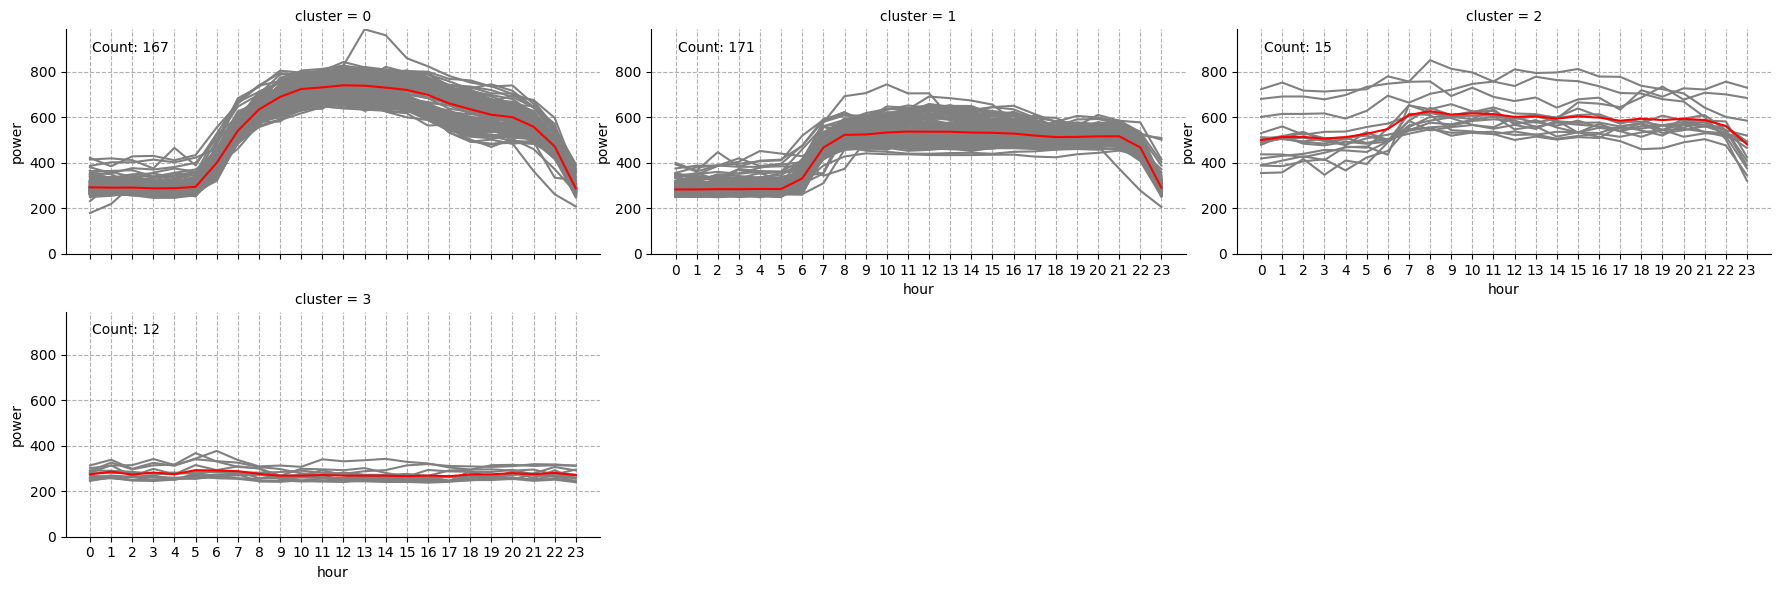

In [18]:
# generating load profiles
g = sns.FacetGrid(data=df, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
i = 0
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax,
                 label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=df['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

    cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
    ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    i += 1

plt.show()

What do you think about the clustering obtained. 

- Are the centroids representative of the daily load profiles within their clusters?
- Do you think it would be interesting to observe the results changing the value of *K*?

Let's observe how clusters of load profiles are distributed across the year.

To this purpose a useful visualization is the calendar plot. Run the following code and observe the results.

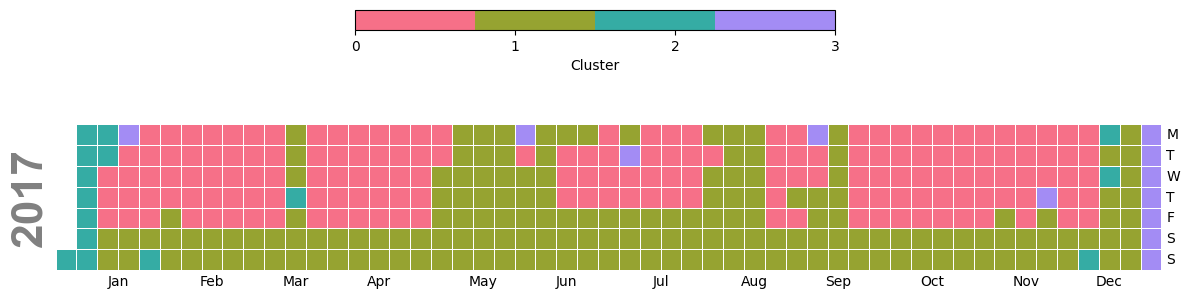

In [19]:
cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(df_matrix.index))

# define colors accordin to palette
colors = sns.color_palette("husl", K)
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)) for color in
              colors]
cmap = ListedColormap(hex_colors)

fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap,
                              fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3,
                              daylabels='MTWTFSS')

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K - 1))
sm.set_array([])
cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Cluster')
cb.set_ticks(np.sort(cal_data['cluster'].unique()))
cb.set_ticklabels(np.sort(cal_data['cluster'].unique()))

plt.show()

8. Try out different values of K. Starting from the analysis of the plots what is the best clustering solution in your opinion? Let's discuss together

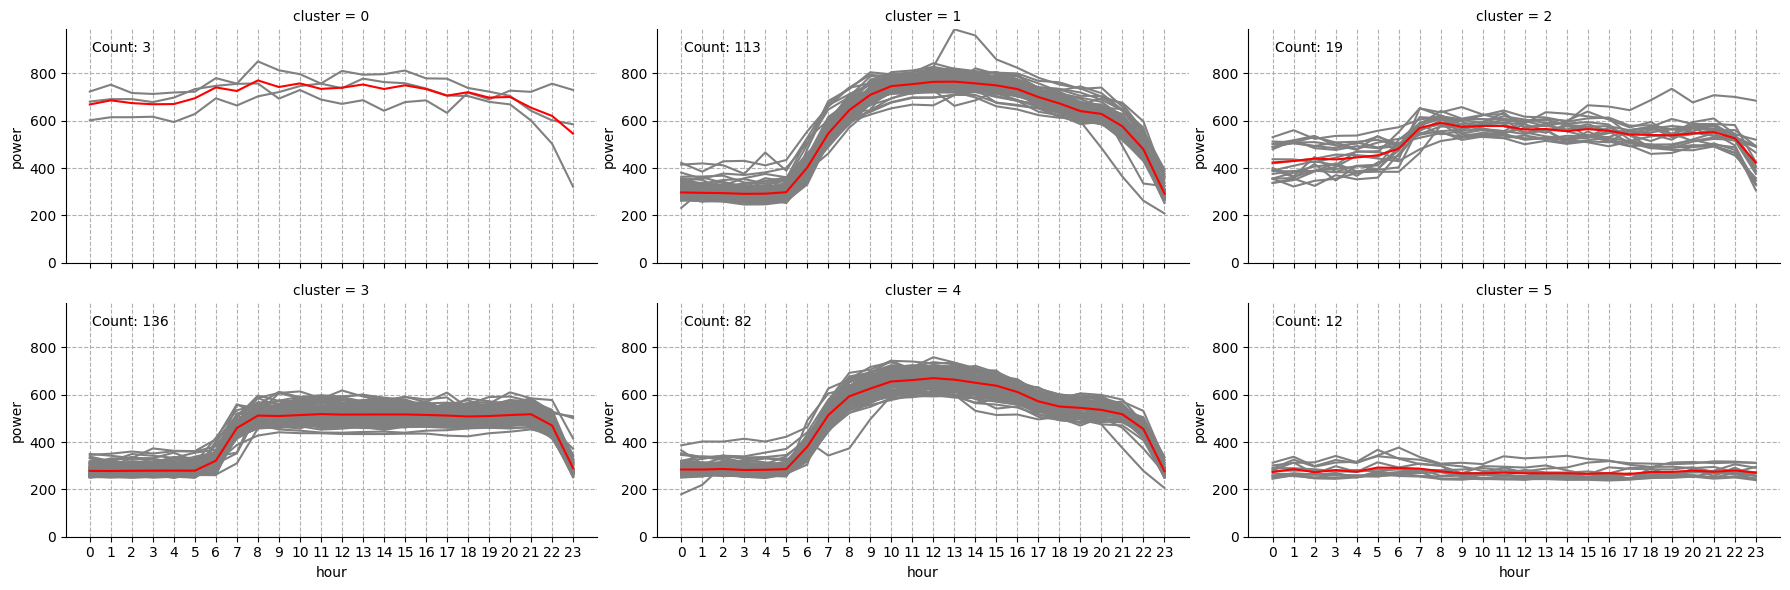

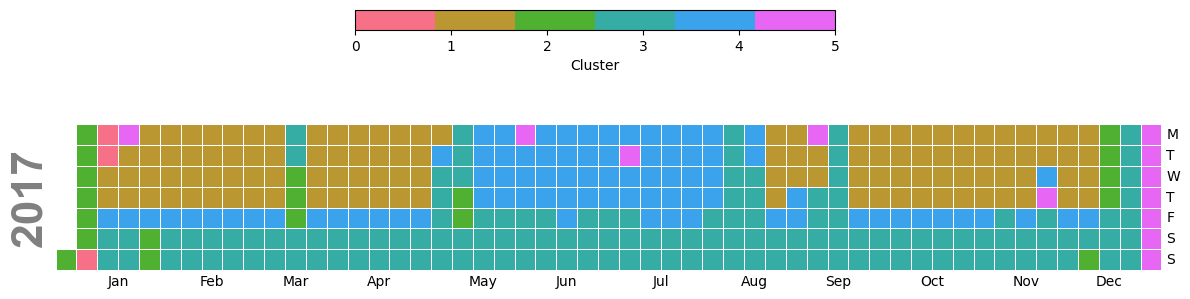

In [21]:
# Perform clustering
K = 6
kmeans = KMeans(n_clusters=K, random_state=0, n_init=10).fit(df_matrix)
labels = kmeans.labels_

cluster_counts = np.unique(labels, return_counts=True)

# Add the cluster labels to the original dataset
df['cluster'] = np.repeat(labels, 24)

# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = df.groupby(['cluster', 'hour'])['power'].mean().reset_index()

# generating load profiles
g = sns.FacetGrid(data=df, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
i = 0
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax,
                 label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=df['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

    cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
    ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    i += 1

plt.show()

# calendar visualization
cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(df_matrix.index))
colors = sns.color_palette("husl", K)
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)) for color in
              colors]
cmap = ListedColormap(hex_colors)

fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap,
                              fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3,
                              daylabels='MTWTFSS')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K - 1))
sm.set_array([])
cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Cluster')
cb.set_ticks(cal_data['cluster'].unique())
cb.set_ticklabels(cal_data['cluster'].unique())

plt.show()

### BONUS: Hierarchical clustering

Agglomerative clustering is a popular hierarchical clustering method used to group similar data points into clusters. It works by initially treating each data point as its own cluster and then iteratively merging the closest clusters until only one cluster containing all data points remains. The merging process is guided by a linkage method that determines how the distance between two clusters is measured.

There are several linkage methods used in agglomerative clustering, each with its own advantages and disadvantages.

The **single** linkage method, also known as the nearest-neighbor method, calculates the distance between the closest two data points in each cluster and merges the two clusters with the smallest distance. This method tends to produce long, narrow clusters and can be sensitive to noise and outliers.

The **complete** linkage method, also known as the farthest-neighbor method, calculates the distance between the furthest two data points in each cluster and merges the two clusters with the largest distance. This method tends to produce compact, spherical clusters but can also be sensitive to noise and outliers.

The **average** linkage method calculates the average distance between all pairs of data points in each cluster and merges the two clusters with the smallest average distance. This method can be less sensitive to noise and outliers than the single and complete linkage methods and tends to produce more balanced clusters.

The **Ward** linkage method minimizes the increase in variance of the clusters resulting from merging them. It tends to produce compact, spherical clusters of similar size and is less sensitive to noise and outliers than the other linkage methods.

Overall, the choice of linkage method in agglomerative clustering depends on the nature of the data and the goals of the analysis. Each method has its own strengths and weaknesses, and selecting the appropriate method can lead to more meaningful and accurate clustering results.

In [22]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

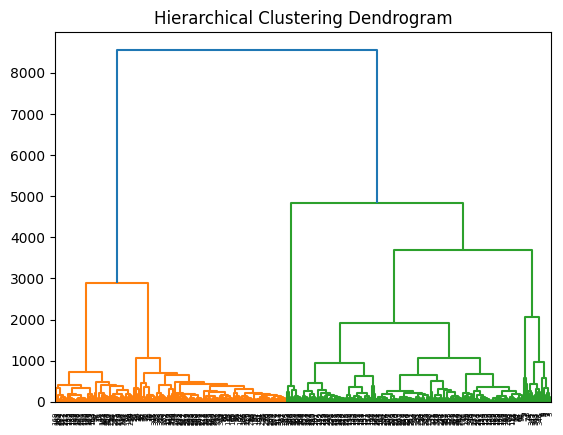

In [23]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="ward").fit(df_matrix)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top (p) levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=0)
plt.show()

9. Try to visualize the dendrogram for the others linkeage methods:
- average
- complete
- single

How does the dendrogram change?

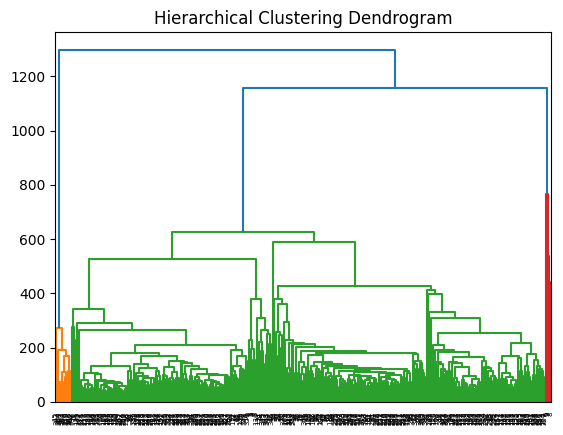

In [24]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="average").fit(df_matrix)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top (p) levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=0)
plt.show()

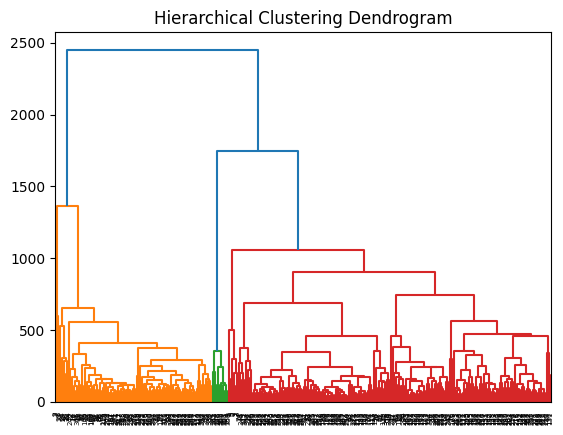

In [25]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="complete").fit(df_matrix)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top (p) levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=0)
plt.show()

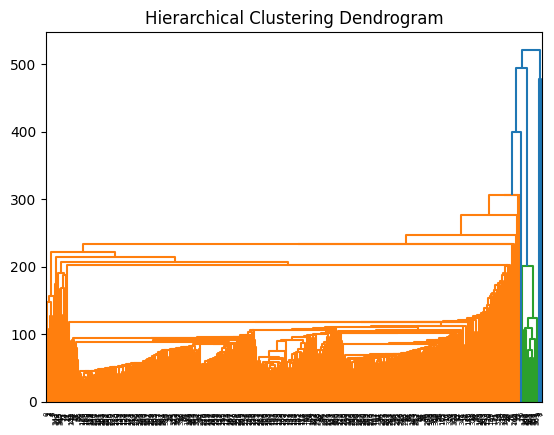

In [26]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage="single").fit(df_matrix)

plt.title("Hierarchical Clustering Dendrogram")
# plot the top (p) levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=0)
plt.show()

10. Write a script that performs grid search for hyperparameter tuning of AgglomerativeClustering model using sklearn's ParameterGrid function. The script should compute the Davies-Bouldin score and Silhouette score for each combination of hyperparameters, and store the results in two separate pandas DataFrames called `db_df` and `sh_df`.

In [27]:
from sklearn.model_selection import ParameterGrid

params = {
    "n_clusters": [2, 3, 4, 5, 6, 7, 8],
    "linkage": ["ward", "average", "complete", "single"]
}

db_df = []
sh_df = []

for config in ParameterGrid(params):
    model = AgglomerativeClustering(**config)
    model.fit(df_matrix)
    db_df.append({
        'linkage': config['linkage'],
        'n_clusters': config['n_clusters'],
        'score': davies_bouldin_score(df_matrix, model.labels_)
    })
    sh_df.append({
        'linkage': config['linkage'],
        'n_clusters': config['n_clusters'],
        'score': silhouette_score(df_matrix, model.labels_)
    })

db_df = pd.DataFrame(db_df)
sh_df = pd.DataFrame(sh_df)


11. Write the script to plot the DB and SH indices as lineplots in function of the number of clusters and for each linkage method. Use lineplot method of seaborn library

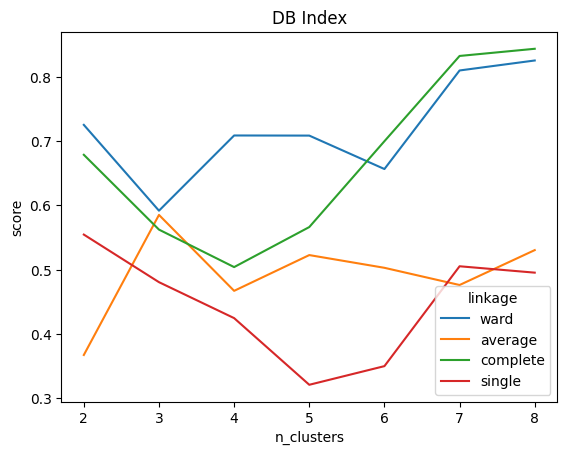

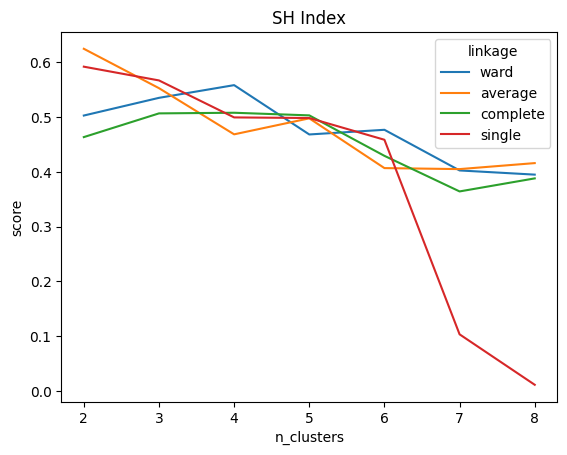

In [28]:
sns.lineplot(x="n_clusters", y="score", hue="linkage", data=db_df)
plt.title("DB Index")
plt.show()

sns.lineplot(x="n_clusters", y="score", hue="linkage", data=sh_df)
plt.title("SH Index")
plt.show()

10. Analyze different *linkage methods* and *number of K* to understand the differences between the different approaches.

In [ ]:
# Perform clustering
K = 4
linkage_method = "ward"  # "complete", "single", "average", "ward"
model = AgglomerativeClustering(distance_threshold=None, n_clusters=K, linkage=linkage_method).fit(df_matrix)
labels = model.labels_

cluster_counts = np.unique(labels, return_counts=True)

# Add the cluster labels to the original dataset
df['cluster'] = np.repeat(labels, 24)

# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = df.groupby(['cluster', 'hour'])['power'].mean().reset_index()

# generating load profiles
g = sns.FacetGrid(data=df, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
i = 0
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax,
                 label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=df['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

    cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
    ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    i += 1

plt.show()

# calendar visualization
cal_data = pd.DataFrame({'cluster': labels}, index=pd.to_datetime(df_matrix.index))
colors = sns.color_palette("husl", K)
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)) for color in
              colors]
cmap = ListedColormap(hex_colors)

fig, ax = calmap.calendarplot(cal_data['cluster'], cmap=cmap,
                              fillcolor='grey', linewidth=0.5, fig_kws=dict(figsize=(12, 4)), monthticks=3,
                              daylabels='MTWTFSS')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=K - 1))
sm.set_array([])
cax = fig.add_axes([0.3, 0.9, 0.4, 0.05])
cb = plt.colorbar(sm, cax=cax, orientation='horizontal')
cb.set_label('Cluster')
cb.set_ticks(cal_data['cluster'].unique())
cb.set_ticklabels(cal_data['cluster'].unique())

plt.show()